In [1]:
import numpy as np 
import pandas as pd 
import json
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime
import glob
import seaborn as sns
import re
import os

In [2]:
#For loop to combine them into one dataframe

files = ['./Resources/Monthly Data/T_ONTIME_REPORTING-1.csv', './Resources/Monthly Data/T_ONTIME_REPORTING-2.csv', './Resources/Monthly Data/T_ONTIME_REPORTING-3.csv', './Resources/Monthly Data/T_ONTIME_REPORTING-4.csv', './Resources/Monthly Data/T_ONTIME_REPORTING-5.csv']
all_dataframes = list()

for csv in files:
  df = pd.read_csv(csv)
  all_dataframes.append(df)


combined_data_v1 = pd.concat(all_dataframes)

In [3]:
#Drop unneccesary columns

combined_data_v2 = combined_data_v1.drop(['CANCELLATION_CODE', 'DIVERTED', 'CARRIER_DELAY', 'WEATHER_DELAY',
                                          'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY'
                                          ], axis=1)


#Drop all rows with NA
combined_data_v2 = combined_data_v2.dropna()
combined_data_v2 

,YEAR,MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,...,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,ARR_TIME_BLK,CANCELLED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE
0,2022,1,3,1/12/2022 12:00:00 AM,YX,N420YX,4904,LGA,BNA,620,...,807,748.0,-19.0,0.0,0800-0859,0.0,167.0,152.0,126.0,764.0
1,2022,1,4,1/13/2022 12:00:00 AM,YX,N124HQ,4904,LGA,BNA,620,...,807,745.0,-22.0,0.0,0800-0859,0.0,167.0,151.0,124.0,764.0
2,2022,1,5,1/14/2022 12:00:00 AM,YX,N425YX,4904,LGA,BNA,620,...,807,800.0,-7.0,0.0,0800-0859,0.0,167.0,131.0,112.0,764.0
3,2022,1,7,1/16/2022 12:00:00 AM,YX,N106HQ,4904,LGA,BNA,620,...,807,746.0,-21.0,0.0,0800-0859,0.0,167.0,157.0,133.0,764.0
4,2022,1,1,1/17/2022 12:00:00 AM,YX,N450YX,4904,LGA,BNA,620,...,807,755.0,-12.0,0.0,0800-0859,0.0,167.0,143.0,120.0,764.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64494,2022,5,3,5/4/2022 12:00:00 AM,OH,N505AE,5433,ALB,DCA,1222,...,1357,1353.0,-4.0,0.0,1300-1359,0.0,95.0,79.0,60.0,318.0
64495,2022,5,7,5/1/2022 12:00:00 AM,OH,N537EA,5433,DCA,ALB,1010,...,1152,1128.0,-24.0,0.0,1100-1159,0.0,102.0,89.0,59.0,318.0
64496,2022,5,1,5/2/2022 12:00:00 AM,OH,N534AE,5433,DCA,ALB,1010,...,1152,1143.0,-9.0,0.0,1100-1159,0.0,102.0,96.0,59.0,318.0
64497,2022,5,2,5/3/2022 12:00:00 AM,OH,N555NN,5433,DCA,ALB,1010,...,1152,1153.0,1.0,0.0,1100-1159,0.0,102.0,95.0,61.0,318.0


# Exporting combinded data for months 1 - 5, 2022

In [4]:
# combined_data_v2.to_csv('./Resources/Allmonths_Flight_Data.csv', index=False)

# Exploratory Data Analysis (EDA)

In [5]:
#Getting summary statistics
dep_max = combined_data_v2['DEP_DELAY'].max()
dep_min = combined_data_v2['DEP_DELAY'].min()
dep_mean = combined_data_v2['DEP_DELAY'].mean()
dep_mode = combined_data_v2['DEP_DELAY'].mode()
dep_sd = combined_data_v2['DEP_DELAY'].std()
dep_md = combined_data_v2['DEP_DELAY'].median()

arr_max = combined_data_v2['ARR_DELAY'].max()
arr_min = combined_data_v2['ARR_DELAY'].min()
arr_mean = combined_data_v2['ARR_DELAY'].mean()
arr_mode = combined_data_v2['ARR_DELAY'].mode()
arr_sd = combined_data_v2['ARR_DELAY'].std()
arr_md = combined_data_v2['ARR_DELAY'].median()

print("Departure Delay")
print("Max: ", dep_max)
print("Min: ", dep_min)
print("Mean: ", dep_mean)
#print(dep_mode)
print("SD: ", dep_sd)
print("Median: ", dep_md)

print(" ")
print("Arrival Delay")
print("Max: ", arr_max)
print("Min: ", arr_min)
print("Mean: ", arr_mean)
#print(arr_mode)
print("SD: ", arr_sd)
print("Median: ", arr_md)


Departure Delay
Max:  2066.0
Min:  -56.0
Mean:  15.590541467230429
SD:  58.05394712436195
Median:  -2.0
 
Arrival Delay
Max:  2052.0
Min:  -95.0
Mean:  9.789198912447922
SD:  61.176912921843915
Median:  -6.0


In [6]:
#Function that classifies delay into 5 sections
def classify(num):
  if (num < 0):
    if (num < -30):
      return ('Early: > 30 mins') 
    else:
      return ('Early: < 30 mins')
  else:
    if (num < 30):
      return ('Late: < 30 mins')
    elif (num < 250):
      return ('Late: < 5 hours')
    else:
      return ('Late: > 5 hours')


#Creating new column for delay group
group_arr_df = combined_data_v2[['ORIGIN', 'DEST', 'ARR_DELAY']]
group_arr_df['Arrival Delay Amount'] = group_arr_df['ARR_DELAY'].apply(lambda x: classify(x))

/Users/alleneapenalex/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
group_arr_df

,ORIGIN,DEST,ARR_DELAY,Arrival Delay Amount
0,LGA,BNA,-19.0,Early: < 30 mins
1,LGA,BNA,-22.0,Early: < 30 mins
2,LGA,BNA,-7.0,Early: < 30 mins
3,LGA,BNA,-21.0,Early: < 30 mins
4,LGA,BNA,-12.0,Early: < 30 mins
...,...,...,...,...
64494,ALB,DCA,-4.0,Early: < 30 mins
64495,DCA,ALB,-24.0,Early: < 30 mins
64496,DCA,ALB,-9.0,Early: < 30 mins
64497,DCA,ALB,1.0,Late: < 30 mins


In [8]:
#Function that classifies delay into 5 sections
def classify(num):
  if (num < 0):
    if (num < -30):
      return ('Early: > 30 mins') 
    else:
      return ('Early: < 30 mins')
  else:
    if (num < 30):
      return ('Late: < 30 mins')
    elif (num < 250):
      return ('Late: < 5 hours')
    else:
      return ('Late: > 5 hours')


#Creating new column for delay group
group_dept_df = combined_data_v2[['ORIGIN', 'DEST', 'DEP_DELAY']]
group_dept_df['Dept Delay Amount'] = group_dept_df['DEP_DELAY'].apply(lambda x: classify(x))

/Users/alleneapenalex/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:
group_dept_df

,ORIGIN,DEST,DEP_DELAY,Dept Delay Amount
0,LGA,BNA,-4.0,Early: < 30 mins
1,LGA,BNA,-6.0,Early: < 30 mins
2,LGA,BNA,29.0,Late: < 30 mins
3,LGA,BNA,-11.0,Early: < 30 mins
4,LGA,BNA,12.0,Late: < 30 mins
...,...,...,...,...
64494,ALB,DCA,12.0,Late: < 30 mins
64495,DCA,ALB,-11.0,Early: < 30 mins
64496,DCA,ALB,-3.0,Early: < 30 mins
64497,DCA,ALB,8.0,Late: < 30 mins


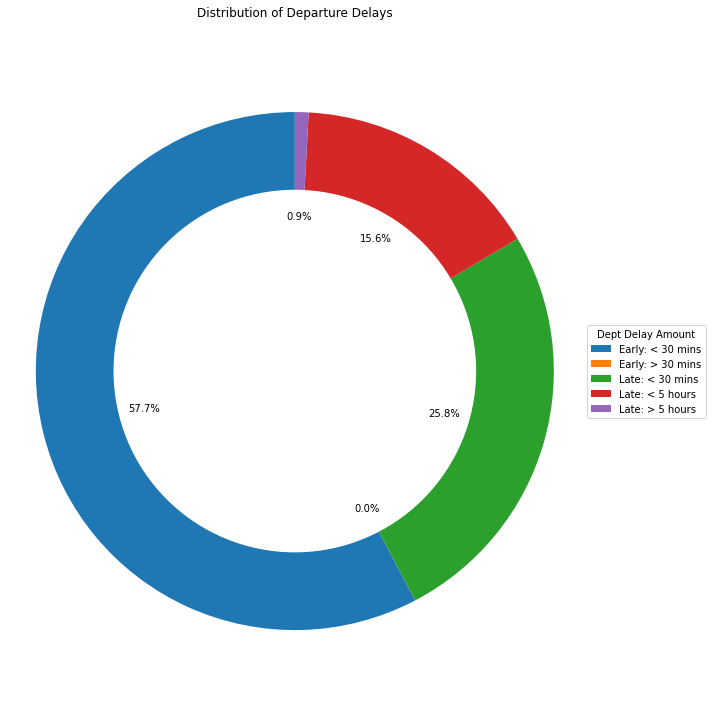

In [10]:
#Plotting Pie Chart
import matplotlib.pyplot as plt

group_dept_count = pd.DataFrame({'Count' : group_dept_df.groupby([ "Dept Delay Amount"] ).size()}).reset_index()

total = group_dept_count['Count'].sum()
group_dept_count['Percent'] = group_dept_count['Count'].apply(lambda x: (x / total) * 100) 
group_dept_count.sort_values('Count', ascending=True)

# Pie chart
labels = group_dept_count['Dept Delay Amount']
sizes = group_dept_count['Percent']
#colors
#colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
#explsion
explode = (0.05,0.05,0.05,0.05, 0.5)


fig1, ax1 = plt.subplots(figsize=(10, 10))
wedges, texts, autotexts = ax1.pie(sizes, autopct='%1.1f%%', startangle=90)

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.legend(wedges, labels,
          title="Dept Delay Amount",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()

plt.setp(texts, size=8, weight="bold")

ax1.set_title("Distribution of Departure Delays")

plt.show()

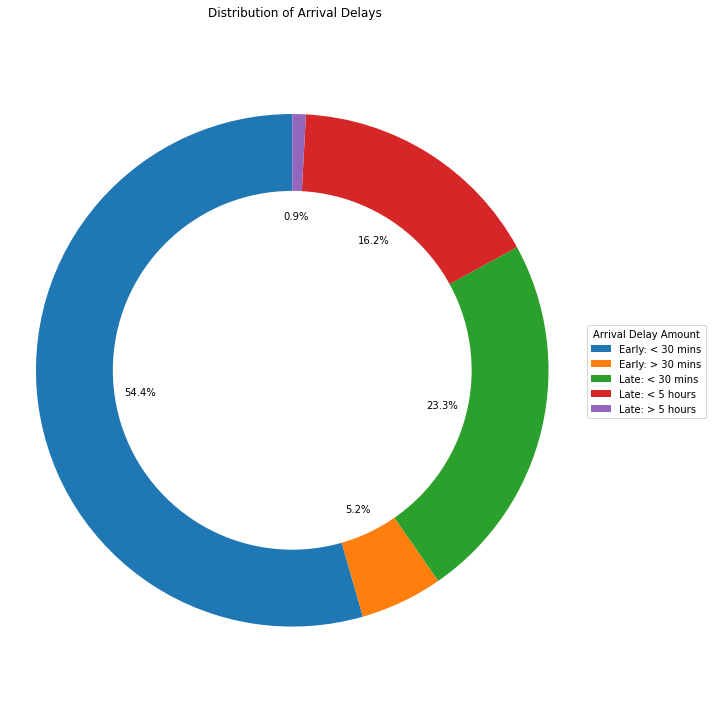

In [11]:
#Plotting Pie Chart
import matplotlib.pyplot as plt

group_arr_count = pd.DataFrame({'Count' : group_arr_df.groupby([ "Arrival Delay Amount"] ).size()}).reset_index()

total = group_arr_count['Count'].sum()
group_arr_count['Percent'] = group_arr_count['Count'].apply(lambda x: (x / total) * 100) 
group_arr_count.sort_values('Count', ascending=True)

# Pie chart
labels = group_arr_count['Arrival Delay Amount']
sizes = group_arr_count['Percent']
#colors
#colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
#explsion
explode = (0.05,0.05,0.05,0.05, 0.5)


fig1, ax1 = plt.subplots(figsize=(10, 10))
wedges, texts, autotexts = ax1.pie(sizes, autopct='%1.1f%%', startangle=90)

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.legend(wedges, labels,
          title="Arrival Delay Amount",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()

plt.setp(texts, size=8, weight="bold")

ax1.set_title("Distribution of Arrival Delays")

plt.show()

In [12]:
#Grouping by origin destination pair
OD_pairs = pd.DataFrame({'Count' : combined_data_v2.groupby([ "ORIGIN", "DEST"] ).size()}).reset_index()
top_OD_pairs = OD_pairs.sort_values('Count', ascending=False).head(10)
top_OD_pairs

,ORIGIN,DEST,Count
338,LGA,ORD,4573
408,ORD,LGA,4558
240,JFK,LAX,4025
282,LAX,JFK,4024
287,LGA,ATL,3315
31,ATL,LGA,3304
292,LGA,BOS,3279
48,BOS,LGA,3268
305,LGA,DCA,2767
112,DCA,LGA,2757


## Top Origins and Destinations

Text(0.5, 0.98, 'Count of incoming/outgoing flights for top 10 busiest airports')

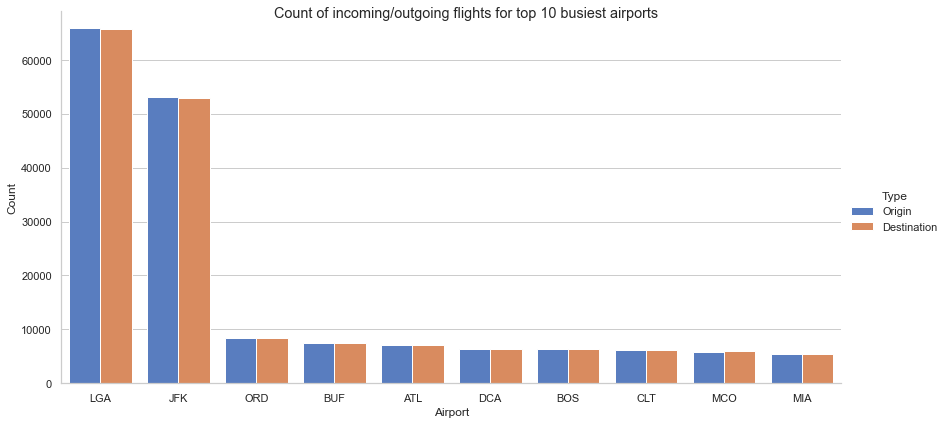

In [13]:
#Group by Origin and Group by Destination
top_origins = pd.DataFrame({'Count' : combined_data_v2.groupby(["ORIGIN"] ).size()}).reset_index().sort_values('Count', ascending=False).head(10)
top_dest = pd.DataFrame({'Count' : combined_data_v2.groupby(["DEST"] ).size()}).reset_index().sort_values('Count', ascending=False).head(10)


#Merging on airport so that for each airport we see how many incoming/outgoing flights there are
top_airports = pd.merge(top_origins, top_dest, how='inner', left_on='ORIGIN', right_on='DEST',)
top_airports = top_airports.drop('DEST', axis=1)
top_airports = top_airports.rename(columns={'Count_x': 'Origin_Count', 'Count_y': 'Dest_Count'})
top_airports['Difference'] = top_airports['Origin_Count'] - top_airports['Dest_Count']

#Renaming Columns
top_origins = top_origins.rename(columns={'ORIGIN': 'Airport'})
top_dest = top_dest.rename(columns={'DEST': 'Airport'})

#Defining if origin or destination
top_origins['Type'] = 'Origin'
top_dest['Type'] = 'Destination'

airports_df = pd.concat([top_origins, top_dest])

#Plotting bar plot
import seaborn as sns

sns.set(style="whitegrid")

# Draw a nested barplot to show survival for class and sex
g = sns.catplot(x="Airport", y="Count", hue="Type", data=airports_df,
                height=6, kind="bar", palette="muted", aspect=2)
g.set_ylabels("Count")
g.fig.suptitle("Count of incoming/outgoing flights for top 10 busiest airports")

## OD Pairs with Highest/Lowest Average Delay

In [14]:
#Group by both origin and destination and getting average delay for that flight
OD_pairs_delay = pd.DataFrame({'avg_delay' : combined_data_v2.groupby([ "ORIGIN", "DEST"] )['ARR_DELAY'].mean(), 
                               'count' : combined_data_v2.groupby([ "ORIGIN", "DEST"] ).size()}).reset_index()
OD_pairs_delay_filter = OD_pairs_delay[OD_pairs_delay['count'] >= 48]
OD_pairs_delay_filter.sort_values('avg_delay', ascending=False).head(20)
OD_pairs_delay_filter.sort_values('avg_delay', ascending=True).head(20)

,ORIGIN,DEST,avg_delay,count
514,SNA,JFK,-15.251748,143
532,SYR,BWI,-6.586375,411
340,LGA,ORH,-5.918033,122
531,SYR,BOS,-5.870000,100
269,JFK,SFO,-5.012579,2703
60,BUF,DFW,-4.531469,143
442,PIE,ELM,-4.509804,51
193,ISP,BWI,-4.047718,482
444,PIE,PBG,-4.019608,51
344,LGA,PNS,-3.433566,143


## Average Delays by Airlines

In [15]:
#Calculating baseline values of average delay for each airline
airline_delay_df = pd.DataFrame({'avg_delay' : combined_data_v2.groupby([ "OP_UNIQUE_CARRIER"] )['ARR_DELAY'].mean()}).reset_index()
airline_delay_df

,OP_UNIQUE_CARRIER,avg_delay
0,9E,4.110933
1,AA,7.015391
2,AS,-2.393488
3,B6,21.105437
4,DL,7.522958
5,F9,25.687985
6,G4,20.480430
7,HA,17.878378
8,MQ,2.845805
9,NK,12.527059


## Correlation Analysis

In [16]:
#Calculating correlation
correlation_data =  combined_data_v2
corr = correlation_data.corr()          

/Users/alleneapenalex/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


<AxesSubplot:>

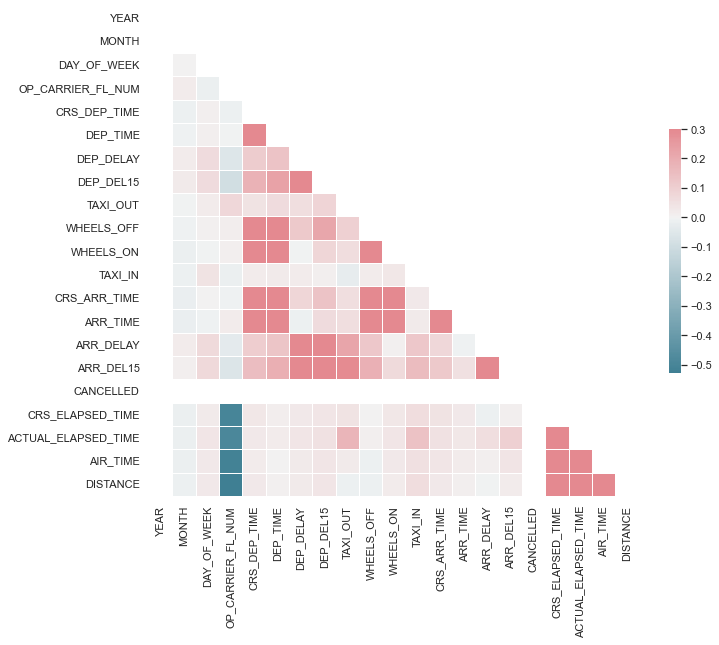

In [17]:
#Plotting Correlation
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})